In [1]:
import os
import csv
import ast
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from collections import defaultdict

from utils import savefig

plt.rcParams['font.size'] = 14

In [2]:
colormap = {
    # "forward_asymmetry": "#264653",
    # "temporal_factor": "#2A9D8F",
    # "explained_variance": "#E9C46A",
    # "cross_decoding": "#F4A261"
    "forward_asymmetry": "tab:purple",
    "temporal_factor": "tab:blue",
    "explained_variance": "tab:green",
    "cross_decoding": "tab:orange",
    "accuracy": "black"
}

In [3]:

def plot_mean_std_scatter(x, y, yerr, x_scatter, y_scatter, x_label, y_label, color='tab:blue', figname=None, vary_x=0.1):
    fig = plt.figure(figsize=(4.3, 3.3), dpi=180)
    plt.errorbar(np.arange(len(y))-vary_x, y, yerr=yerr, fmt='o', alpha=0.8, capsize=3, color=color)
    unique_x_values = np.unique(x_scatter)
    data_to_plot = [y_scatter[x_scatter == x_val] for x_val in unique_x_values]
    # plt.boxplot(data_to_plot, positions=np.arange(len(unique_x_values)) - vary_x, widths=0.1)
    
    # Update the scatter plot to use integer x-axis
    x_scatter_int = np.array([np.where(unique_x_values == x)[0][0] for x in x_scatter])
    plt.scatter(x_scatter_int + vary_x, y_scatter, alpha=0.3, color=color, s=15)
    plt.xticks(ticks=range(len(unique_x_values)), labels=[f"{x_val:.1f}" for x_val in unique_x_values])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/vary_gamma", figname)
    else:
        plt.show()


def plot_scatter(x, y, x_label, y_label, color='tab:blue', figname=None):
    plt.figure(figsize=(4, 3.5), dpi=180)
    plt.scatter(x, y, alpha=0.5, color=color)

    # Reshape x and y for sklearn
    x_reshaped = np.array(x).reshape(-1, 1)
    y_reshaped = np.array(y).reshape(-1, 1)

    # Fit linear regression model
    model = LinearRegression()
    model.fit(x_reshaped, y_reshaped)

    # Predict y values
    sorted_x_idx = np.argsort(x_reshaped.reshape(-1))
    x1, x2 = x_reshaped[sorted_x_idx[0]], x_reshaped[sorted_x_idx[-1]]
    y_pred = model.predict(x_reshaped)
    y1, y2 = y_pred[sorted_x_idx[0]], y_pred[sorted_x_idx[-1]]

    # Calculate R-squared
    r2 = r2_score(y_reshaped, y_pred)
    # Calculate the p-value for the regression
    _, p_value = stats.pearsonr(x_reshaped.flatten(), y_reshaped.flatten())
    
    # Plot the regression line
    # plt.plot([x1, x2], [y1, y2], color=color)

    plt.ylabel(y_label)
    # plt.xlabel(x_label+"\n(R² = {:.2f}, p = {:.3f})".format(r2, p_value))
    plt.xlabel(x_label)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/scatter", figname)
    else:
        plt.show()

In [4]:
data_folder = Path("./experiments/VaryNoise/figures/ValueMemoryGRU")
training_curve_folder = Path("./experiments/VaryNoise/saved_models/ValueMemoryGRU")
# setup_names = ["setup_seq8_noise{}".format(i) for i in ["0", "02", "04", "06", "08", "1"]]
seq_lens = [8, 16]
noise_levels = np.round(np.arange(0.0, 1.1, 0.2), 1)
noise_names = ["0", "02", "04", "06", "08", "1"]
performance_threshold = 0.7

data = []


def load_data(path, seq_len, noise, training_data_length=200):
    data_single_model = {}
    with open(path/"contiguity_effect.csv", "r") as f:
        reader = csv.reader(f)
        for row in reader:
            # if float(row[0]) >= performance_threshold:
            data_single_model["seq_len"] = seq_len
            data_single_model["noise"] = noise
            data_single_model["accuracy"] = float(row[0])
            data_single_model["forward_asymmetry"] = float(row[1])
            data_single_model["temporal_factor"] = float(row[2])

            classifier_data = pickle.load(open(path/"ridge_classifier_stat.pkl", "rb"))
            data_single_model["index_decoding_accuracy_encoding_phase"] = classifier_data["index_enc_acc"]
            data_single_model["item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc"]
            data_single_model["last_item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc_last"]
            data_single_model["index_decoding_accuracy_recall_phase"] = classifier_data["index_rec_acc"]
            data_single_model["item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc"]
            data_single_model["last_item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc_last"]

            explained_variance_data = np.load(path/"explained_variance.npy")
            data_single_model["explained_variance_encoding_index"] = explained_variance_data[0]
            data_single_model["explained_variance_recall_index"] = explained_variance_data[1]
            data_single_model["explained_variance_encoding_identity"] = explained_variance_data[2]
            data_single_model["explained_variance_recall_identity"] = explained_variance_data[3]

            cross_decoding_data = np.load(path/"cross_acc.npy")
            data_single_model["cross_decoding_accuracy_index_rec_enc"] = cross_decoding_data[0]
            data_single_model["cross_decoding_accuracy_identity_rec_enc"] = cross_decoding_data[1]
            data_single_model["cross_decoding_accuracy_index_enc_rec"] = cross_decoding_data[2]
            data_single_model["cross_decoding_accuracy_identity_enc_rec"] = cross_decoding_data[3]

            training_data_path = training_curve_folder / (setup_name + '-' + str(i))
            try:
                training_data = np.load(training_data_path/"accuracy_2.npy")
            except:
                training_data = np.load(training_data_path/"accuracy_1.npy")
            # find the final consecutive zeros in the training data and set it to the last non-zero value
            zero_indices = np.where(training_data == 0)[0]
            if len(zero_indices) > 0:
                last_zero_index = zero_indices[0]
                training_data[last_zero_index:] = training_data[last_zero_index-1]
            if training_data.shape[0] < training_data_length:
                training_data = np.pad(training_data, (0, training_data_length - training_data.shape[0]), mode='constant', constant_values=training_data[-1])
            data_single_model["training_accuracy"] = training_data
    return data_single_model



for noise_level, noise_name in zip(noise_levels, noise_names):
    for seq_len in seq_lens:
        setup_name = "setup_seq{}_noise{}".format(seq_len, noise_name)
        setup_name_pretrained = "setup_pretrain_seq{}_noise{}".format(seq_len, noise_name)
        if seq_len == 8:
            training_data_length = 200
        else:
            training_data_length = 500
        for i in range(20):
            data_path = data_folder / setup_name / str(i)
            if os.path.exists(data_path/"contiguity_effect.csv"):
                data_single_model = load_data(data_path, seq_len, noise_level, training_data_length)
                if data_single_model:
                    data_single_model["pretrained"] = False
                    data.append(data_single_model)

            data_path_pretrained = data_folder / setup_name_pretrained / str(i)
            if os.path.exists(data_path_pretrained/"contiguity_effect.csv"):
                data_single_model_pretrained = load_data(data_path_pretrained, seq_len, noise_level, training_data_length)
                if data_single_model_pretrained:
                    data_single_model_pretrained["pretrained"] = True
                    data.append(data_single_model_pretrained)
            

df_noise = pd.DataFrame(data)
df_noise.head()
print(len(data))


240


In [5]:
df_seq8 = df_noise[(df_noise["seq_len"] == 8) & (df_noise["pretrained"] == False) & (df_noise["accuracy"] > performance_threshold)]

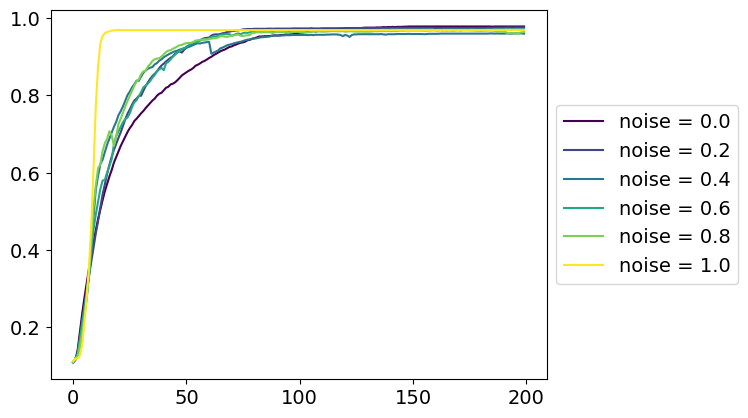

In [6]:
training_accuracy_seq8 = df_seq8["training_accuracy"].groupby(df_seq8["noise"]).mean()

colors = plt.cm.viridis(np.linspace(0, 1, len(training_accuracy_seq8)))
for i, (noise, acc) in enumerate(training_accuracy_seq8.items()):
    plt.plot(acc[:200], label=f"noise = {noise:.1f}", color=colors[i])
# set the legend to the right of the plot
ax = plt.gca()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

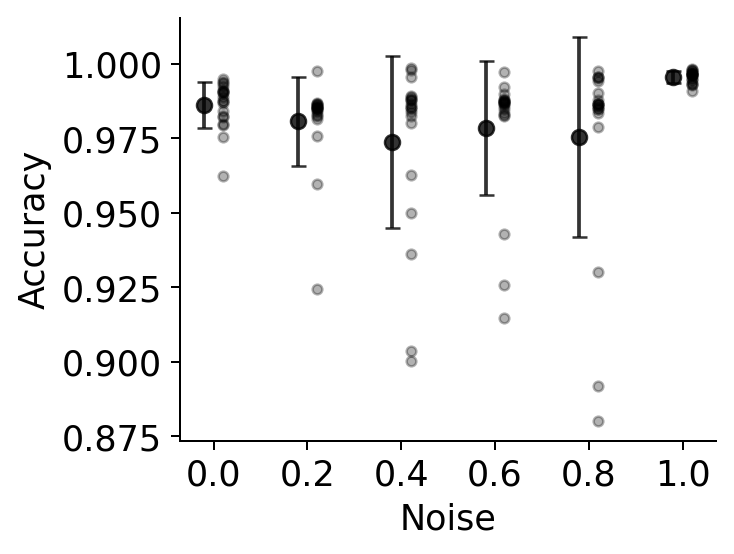

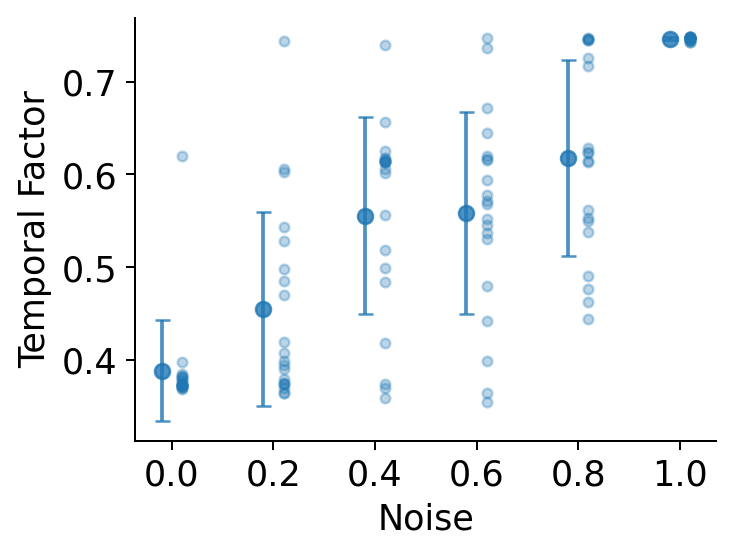

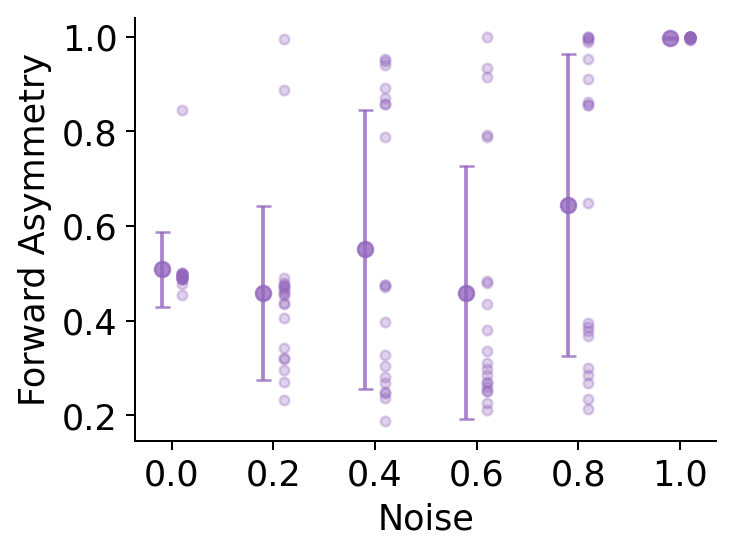

In [7]:
accuracy_mean_by_noise = df_seq8.groupby("noise")["accuracy"].mean()
accuracy_std_by_noise = df_seq8.groupby("noise")["accuracy"].std()

temporal_factor_mean_by_noise = df_seq8.groupby("noise")["temporal_factor"].mean()
temporal_factor_std_by_noise = df_seq8.groupby("noise")["temporal_factor"].std()

forward_asymmetry_mean_by_noise = df_seq8.groupby("noise")["forward_asymmetry"].mean()
forward_asymmetry_std_by_noise = df_seq8.groupby("noise")["forward_asymmetry"].std()

noise_all = df_seq8["noise"]
accuracy_all = df_seq8["accuracy"]
temporal_factor_all = df_seq8["temporal_factor"]
forward_asymmetry_all = df_seq8["forward_asymmetry"]


plot_mean_std_scatter(noise_levels, accuracy_mean_by_noise, accuracy_std_by_noise, noise_all, accuracy_all, "Noise", "Accuracy", colormap["accuracy"])
plot_mean_std_scatter(noise_levels, temporal_factor_mean_by_noise, temporal_factor_std_by_noise, noise_all, temporal_factor_all, "Noise", "Temporal Factor", colormap["temporal_factor"])
plot_mean_std_scatter(noise_levels, forward_asymmetry_mean_by_noise, forward_asymmetry_std_by_noise, noise_all, forward_asymmetry_all, "Noise", "Forward Asymmetry", colormap["forward_asymmetry"])

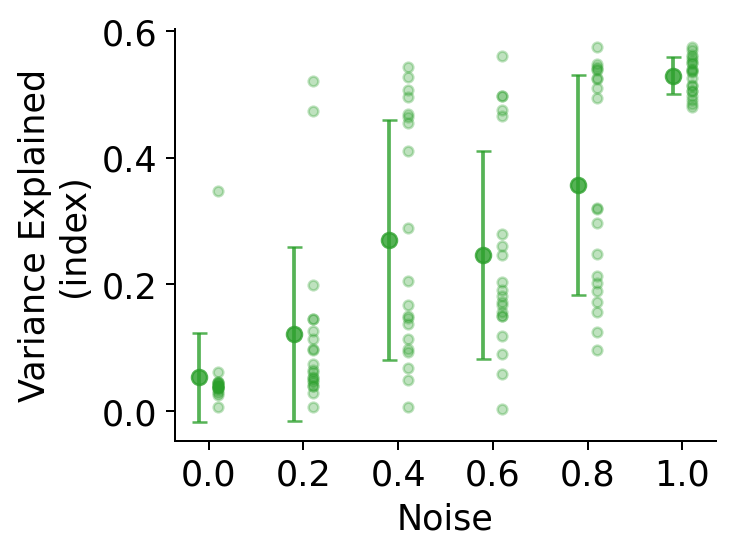

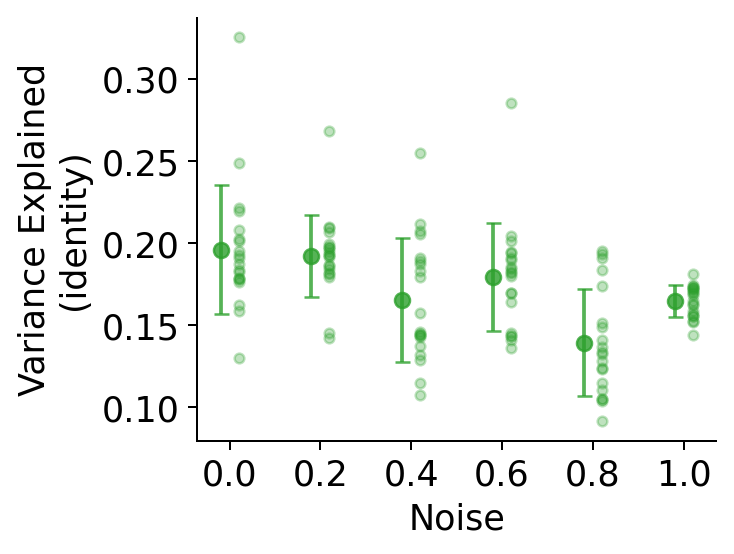

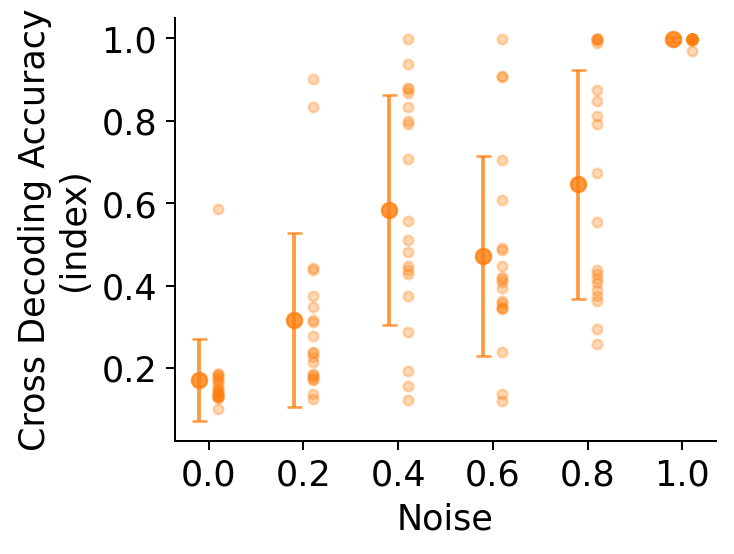

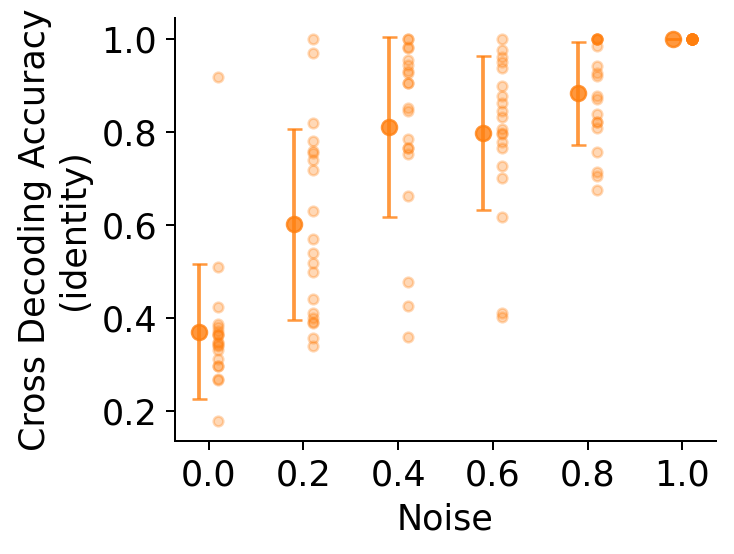

In [9]:
df_seq8.loc[:, "variance_explained_index"] = (df_seq8["explained_variance_encoding_index"] + df_seq8["explained_variance_recall_index"]) / 2
df_seq8.loc[:, "variance_explained_identity"] = (df_seq8["explained_variance_encoding_identity"] + df_seq8["explained_variance_recall_identity"]) / 2

df_seq8.loc[:, "cross_decoding_accuracy_index"] = (df_seq8["cross_decoding_accuracy_index_rec_enc"] + df_seq8["cross_decoding_accuracy_index_enc_rec"]) / 2
df_seq8.loc[:, "cross_decoding_accuracy_identity"] = (df_seq8["cross_decoding_accuracy_identity_rec_enc"] + df_seq8["cross_decoding_accuracy_identity_enc_rec"]) / 2


variance_explained_index_all = df_seq8["variance_explained_index"]
variance_explained_identity_all = df_seq8["variance_explained_identity"]
cross_decoding_accuracy_index_all = df_seq8["cross_decoding_accuracy_index"]
cross_decoding_accuracy_identity_all = df_seq8["cross_decoding_accuracy_identity"]

variance_explained_index_mean_by_noise = df_seq8.groupby("noise")["variance_explained_index"].mean()
variance_explained_index_std_by_noise = df_seq8.groupby("noise")["variance_explained_index"].std()
variance_explained_identity_mean_by_noise = df_seq8.groupby("noise")["variance_explained_identity"].mean()
variance_explained_identity_std_by_noise = df_seq8.groupby("noise")["variance_explained_identity"].std()

cross_decoding_accuracy_index_mean_by_noise = df_seq8.groupby("noise")["cross_decoding_accuracy_index"].mean()
cross_decoding_accuracy_index_std_by_noise = df_seq8.groupby("noise")["cross_decoding_accuracy_index"].std()
cross_decoding_accuracy_identity_mean_by_noise = df_seq8.groupby("noise")["cross_decoding_accuracy_identity"].mean()
cross_decoding_accuracy_identity_std_by_noise = df_seq8.groupby("noise")["cross_decoding_accuracy_identity"].std()


plot_mean_std_scatter(noise_levels, variance_explained_index_mean_by_noise, variance_explained_index_std_by_noise, noise_all, variance_explained_index_all, "Noise", "Variance Explained\n(index)", colormap["explained_variance"])
plot_mean_std_scatter(noise_levels, variance_explained_identity_mean_by_noise, variance_explained_identity_std_by_noise, noise_all, variance_explained_identity_all, "Noise", "Variance Explained\n(identity)", colormap["explained_variance"])
plot_mean_std_scatter(noise_levels, cross_decoding_accuracy_index_mean_by_noise, cross_decoding_accuracy_index_std_by_noise, noise_all, cross_decoding_accuracy_index_all, "Noise", "Cross Decoding Accuracy\n(index)", colormap["cross_decoding"])
plot_mean_std_scatter(noise_levels, cross_decoding_accuracy_identity_mean_by_noise, cross_decoding_accuracy_identity_std_by_noise, noise_all, cross_decoding_accuracy_identity_all, "Noise", "Cross Decoding Accuracy\n(identity)", colormap["cross_decoding"])


In [10]:
df_seq8_filtered = df_seq8[df_seq8["temporal_factor"] > 0.4]

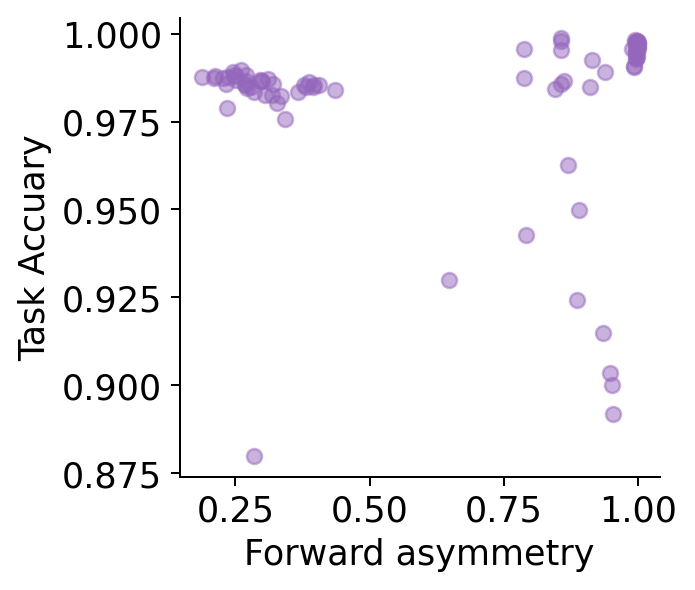

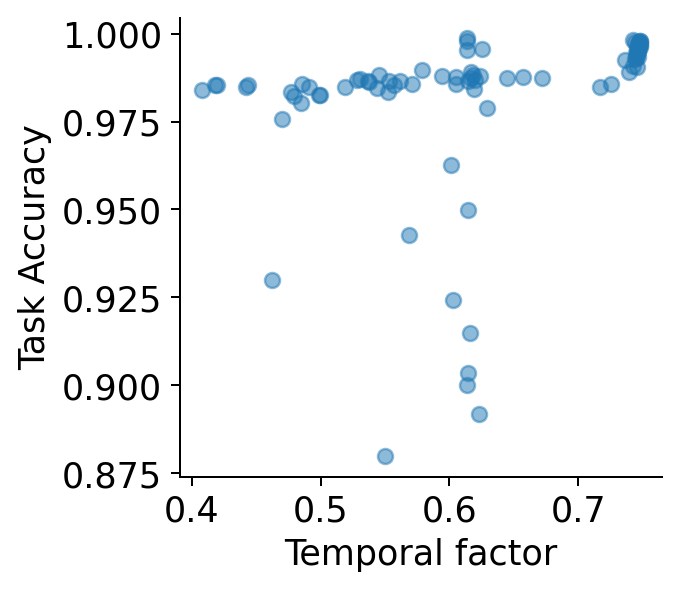

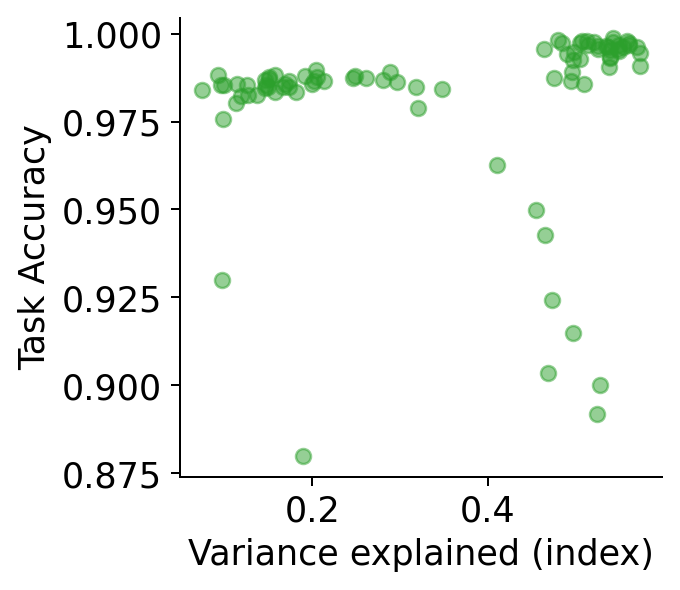

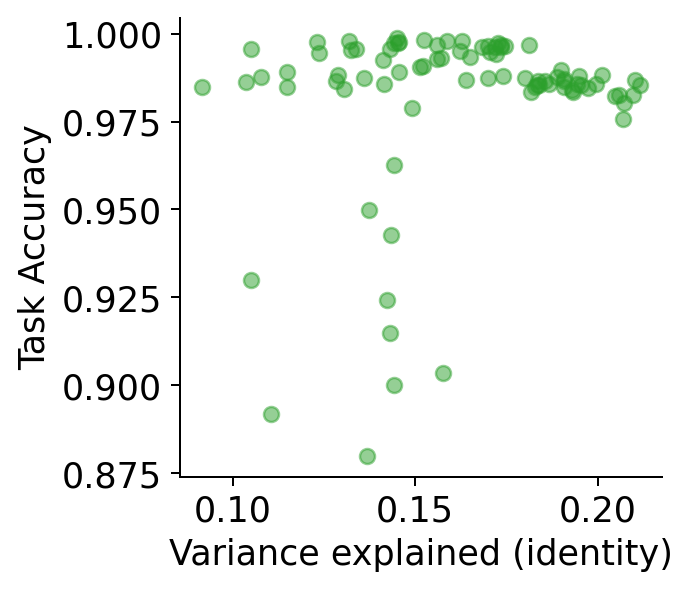

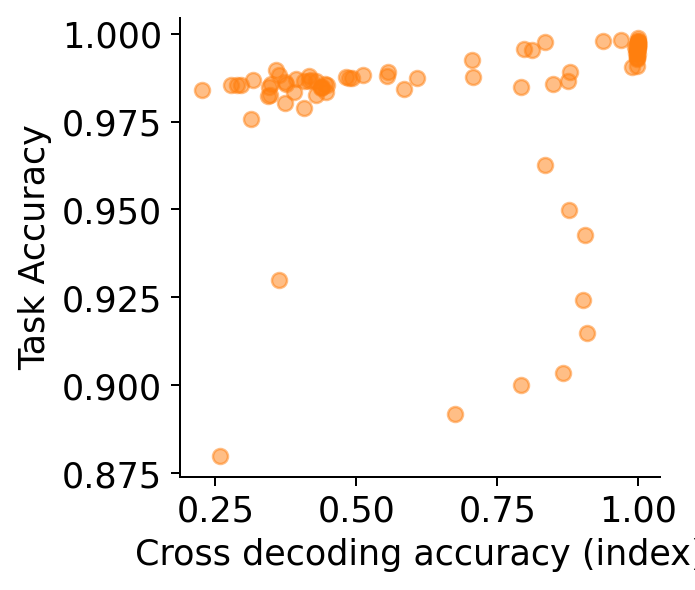

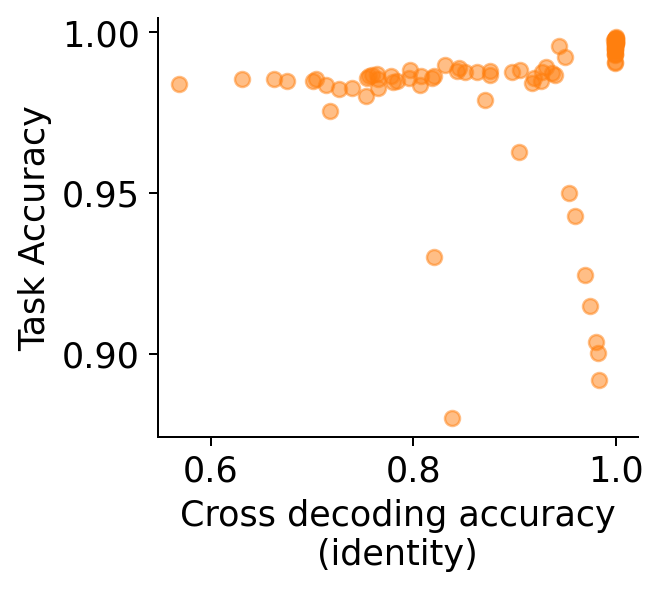

In [11]:
plot_scatter(df_seq8_filtered["forward_asymmetry"], df_seq8_filtered["accuracy"], "Forward asymmetry", "Task Accuary", color=colormap["forward_asymmetry"])
plot_scatter(df_seq8_filtered["temporal_factor"], df_seq8_filtered["accuracy"], "Temporal factor", "Task Accuracy", color=colormap["temporal_factor"])
plot_scatter(df_seq8_filtered["variance_explained_index"], df_seq8_filtered["accuracy"], "Variance explained (index)", "Task Accuracy", color=colormap["explained_variance"])
plot_scatter(df_seq8_filtered["variance_explained_identity"], df_seq8_filtered["accuracy"], "Variance explained (identity)", "Task Accuracy", color=colormap["explained_variance"])
plot_scatter(df_seq8_filtered["cross_decoding_accuracy_index"], df_seq8_filtered["accuracy"], "Cross decoding accuracy (index)", "Task Accuracy", color=colormap["cross_decoding"])
plot_scatter(df_seq8_filtered["cross_decoding_accuracy_identity"], df_seq8_filtered["accuracy"], "Cross decoding accuracy\n(identity)", "Task Accuracy", color=colormap["cross_decoding"])




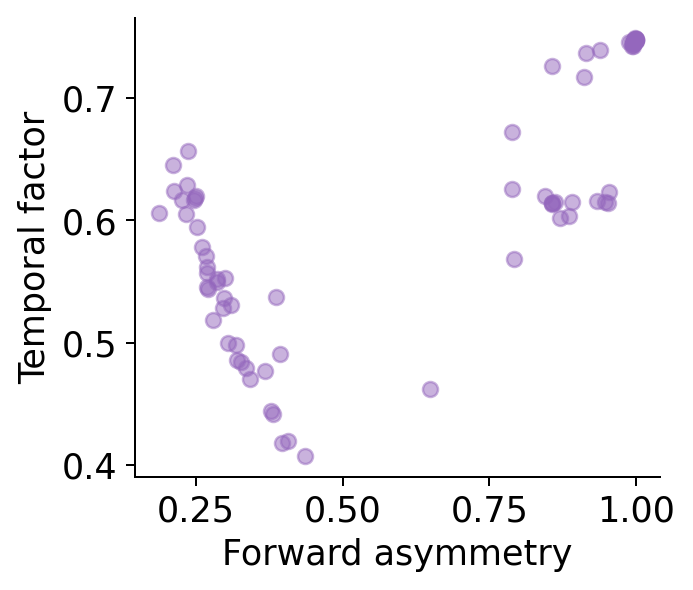

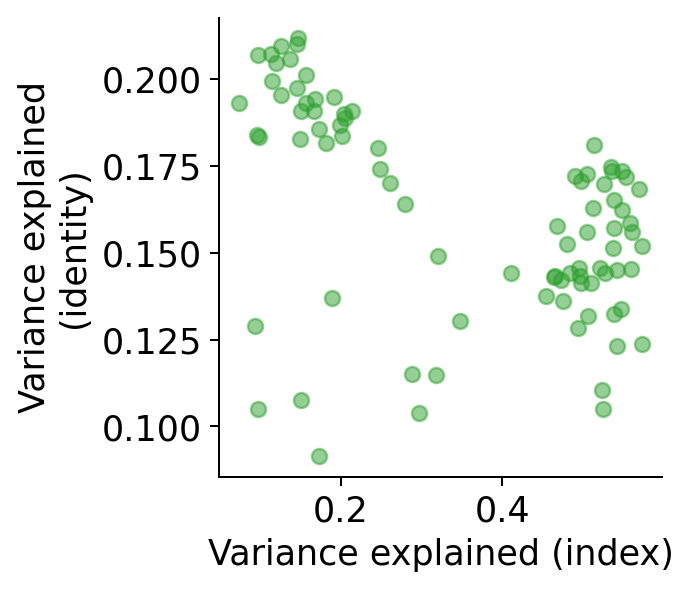

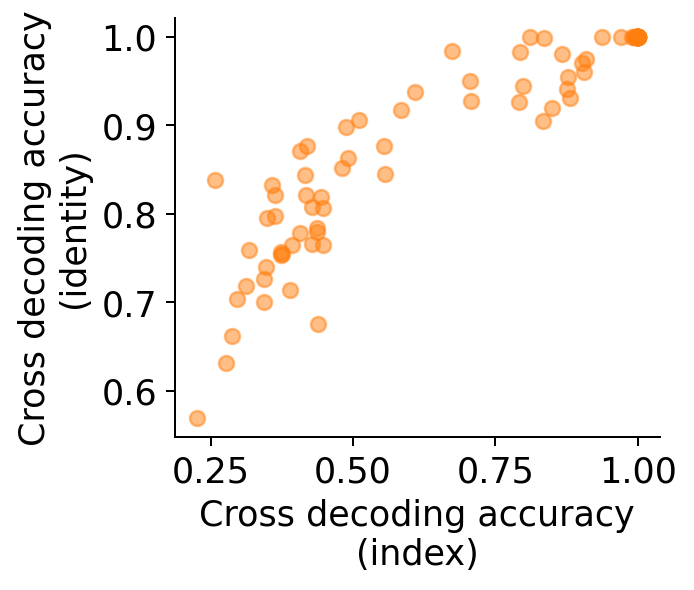

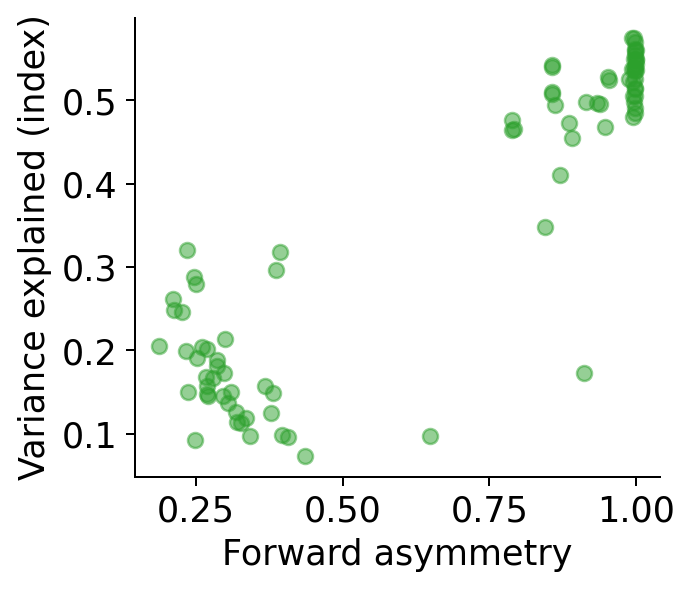

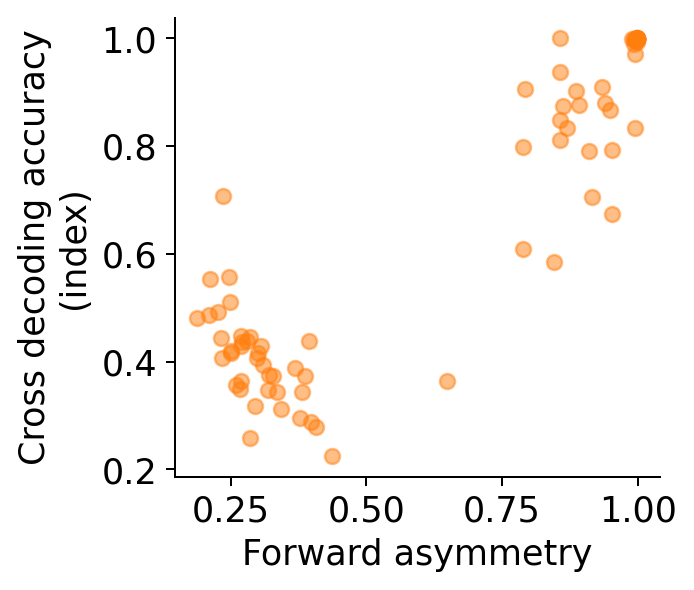

In [12]:
plot_scatter(df_seq8_filtered["forward_asymmetry"], df_seq8_filtered["temporal_factor"], "Forward asymmetry", "Temporal factor", color=colormap["forward_asymmetry"])
plot_scatter(df_seq8_filtered["variance_explained_index"], df_seq8_filtered["variance_explained_identity"], "Variance explained (index)", "Variance explained\n(identity)", color=colormap["explained_variance"])
plot_scatter(df_seq8_filtered["cross_decoding_accuracy_index"], df_seq8_filtered["cross_decoding_accuracy_identity"], "Cross decoding accuracy\n(index)", "Cross decoding accuracy\n(identity)", color=colormap["cross_decoding"])

plot_scatter(df_seq8_filtered["forward_asymmetry"], df_seq8_filtered["variance_explained_index"], "Forward asymmetry", "Variance explained (index)", color=colormap["explained_variance"])
plot_scatter(df_seq8_filtered["forward_asymmetry"], df_seq8_filtered["cross_decoding_accuracy_index"], "Forward asymmetry", "Cross decoding accuracy\n(index)", color=colormap["cross_decoding"])


